# Whales classification task

https://www.kaggle.com/c/noaa-right-whale-recognition

Predict the ID of each whale photo

Assumes that you have already downloaded the zip files from kaggle and unzipped them.

Steps
- unpack dataset
- extract validation data
- load VGG model from Keras, without the top layers
- add 2 hidden layers and an output layer for classification
- visualize the results (might be hard to do for a non-expert)
- submit to Kaggle

In [1]:
%matplotlib inline

In [2]:
root_path = "data/whales/"

path = root_path + "imgs/"
#path = root_path + "imgs_subset/"

dataset_needs_unpacked = False # set to True when starting from scratch

In [20]:
from __future__ import division,print_function

import os, json, shutil, random, math
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from utils import plots, save_array, load_array

In [4]:
def plot_train_validation_curves(title, training_series, validation_series):
    num_epochs = len(training_series)
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, validation_series, label='validation')
    plt.plot(epochs, training_series, label='train')
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Unpack the dataset
Unpack the dataset so that it's in a format which works with Keras' ImageDataGenerator.flow_from_directory()

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

if dataset_needs_unpacked:
    # create the directory structure
    os.mkdir(path + "train")
    os.mkdir(path + "validation")
    os.mkdir(path + "test")

    # create directories for each label (whale_id)
    train_table = pd.read_csv(root_path+'train.csv', index_col='Image')
    whale_ids = list(train_table['whaleID'].unique())

    for whale_id in whale_ids:
        os.mkdir(path + "train/" + whale_id)
        os.mkdir(path + "validation/" + whale_id)
    os.mkdir(path + "test/unknown")

    train_fnames, validation_fnames = train_test_split(train_table.index, train_size=0.8)
    print("Train/Validation split size:", (len(train_fnames), len(validation_fnames)))

    def create_folder_hierarchy(fnames, namespace):
        num_skipped = 0
        for fname in fnames:
            if not os.path.exists(path + fname):
                num_skipped += 1
                print("Skipping {} because not found on disk".format(fname))
                continue
            whale_id = train_table.loc[fname, 'whaleID']
            src = path + fname
            dest = os.path.join(path, namespace, whale_id, fname)
            os.rename(src, dest)
        print("Total skipped: ", num_skipped)

    # move the labeled images into appropriate directories
    create_folder_hierarchy(train_fnames, "train")
    create_folder_hierarchy(validation_fnames, "validation")

    # for all remaining, unlabeled images, put them in the `test/unknown` directory
    for img_path in glob(path + "w_*.jpg"):
        shutil.move(img_path, path + "test/unknown/")

OSError: [Errno 17] File exists: 'data/whales/imgs/train'

# Fine-tune VGG 16 model to classify the whales
There are 447 unique whales in the dataset

In [6]:
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback, LearningRateScheduler, ReduceLROnPlateau

import vgg16_keith; reload(vgg16_keith)

vgg = vgg16_keith.FineTunedVgg16(num_classes=447)
vgg.compile(optimizer=RMSprop(lr=0.001))

In [7]:
MODE_TRAIN      = 'mode_train'
MODE_VALIDATION = 'mode_validation'
MODE_TEST       = 'mode_test'

def get_batches(batch_mode, batch_size=64):
    if batch_mode == MODE_TRAIN:
        img_dir = path+'train'
        class_mode = 'categorical'
        gen = ImageDataGenerator(rotation_range=360, width_shift_range=0.1, height_shift_range=0.1, 
                                 horizontal_flip=True, vertical_flip=True, zoom_range=0.2)
    elif batch_mode == MODE_VALIDATION:
        img_dir = path+'validation'
        class_mode = 'categorical'
        gen = ImageDataGenerator()
    elif batch_mode == MODE_TEST:
        img_dir = path+'test'
        class_mode = None
        gen = ImageDataGenerator()
        
    return gen.flow_from_directory(img_dir, target_size=(224,224), class_mode=class_mode, batch_size=batch_size)

In [8]:
batch_size = 128
train_batches = get_batches(MODE_TRAIN, batch_size=batch_size)
validation_batches = get_batches(MODE_VALIDATION, batch_size=batch_size)

Found 3634 images belonging to 447 classes.
Found 909 images belonging to 447 classes.


In [9]:
validation_batches.nb_class

447

In [10]:
num_epochs = 30
callbacks = [ModelCheckpoint(path+'weights.{epoch:02d}-{val_loss:.2f}.hdf5', save_weights_only=True)]
hist = vgg.fit(train_batches, validation_batches, num_epochs=num_epochs, callbacks=callbacks)

Epoch 1/30
3634/3634 [==============================] - 574s - loss: 8.6221 - acc: 0.0061 - val_loss: 7.0296 - val_acc: 0.0110
Epoch 2/30
3634/3634 [==============================] - 455s - loss: 7.6139 - acc: 0.0107 - val_loss: 6.9355 - val_acc: 0.0066
Epoch 3/30
3634/3634 [==============================] - 454s - loss: 7.2687 - acc: 0.0190 - val_loss: 7.0728 - val_acc: 0.0154
Epoch 4/30
3634/3634 [==============================] - 459s - loss: 7.0644 - acc: 0.0226 - val_loss: 7.2099 - val_acc: 0.0143
Epoch 5/30
3634/3634 [==============================] - 458s - loss: 6.9013 - acc: 0.0303 - val_loss: 7.0503 - val_acc: 0.0209
Epoch 6/30
3634/3634 [==============================] - 460s - loss: 6.7864 - acc: 0.0371 - val_loss: 7.2247 - val_acc: 0.0242
Epoch 7/30
3634/3634 [==============================] - 456s - loss: 6.6755 - acc: 0.0443 - val_loss: 7.1538 - val_acc: 0.0319
Epoch 8/30
1664/3634 [============>.................] - ETA: 104s - loss: 6.5094 - acc: 0.0463

KeyboardInterrupt: 

In [ ]:
plot_train_validation_curves('Accuracy', hist.history['acc'], hist.history['val_acc'])
plot_train_validation_curves('Loss', hist.history['loss'], hist.history['val_loss'])

# Try it out

In [13]:
dummy_batches = get_batches(MODE_VALIDATION, batch_size=6)

Found 909 images belonging to 447 classes.


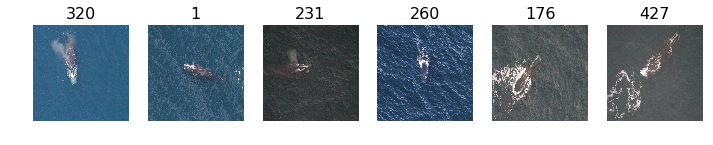

In [14]:
imgs, labels = next(dummy_batches)
plots(imgs, titles=np.argmax(labels, axis=1))

In [15]:
preds = vgg.model.predict(imgs)
np.argmax(preds, axis=1)

array([272, 272, 387, 424, 266, 242])

In [35]:
dummy_batches.filenames[:7]

['whale_00195/w_6326.jpg',
 'whale_00195/w_8913.jpg',
 'whale_00195/w_9206.jpg',
 'whale_00195/w_5270.jpg',
 'whale_00442/w_7552.jpg',
 'whale_02411/w_5249.jpg',
 'whale_02608/w_1582.jpg']

In [40]:
dummy_batches.classes

array([  0,   0,   0,   0,   1,   2,   3,   4,   4,   6,   6,   6,   6,   8,   8,   9,   9,  10,
        11,  11,  11,  12,  13,  14,  15,  17,  17,  19,  19,  19,  20,  21,  21,  23,  23,  23,
        24,  24,  25,  25,  27,  28,  28,  28,  28,  29,  30,  30,  31,  31,  31,  31,  31,  32,
        32,  32,  32,  32,  33,  33,  34,  34,  35,  35,  36,  36,  38,  38,  38,  38,  38,  40,
        41,  42,  42,  43,  43,  43,  45,  45,  47,  47,  47,  48,  48,  49,  49,  50,  50,  51,
        52,  52,  53,  54,  55,  56,  57,  57,  58,  59,  59,  62,  62,  63,  63,  64,  64,  65,
        65,  66,  68,  70,  71,  72,  73,  73,  73,  73,  74,  75,  78,  78,  78,  78,  79,  79,
        79,  79,  80,  80,  80,  80,  80,  81,  81,  82,  84,  84,  84,  84,  85,  86,  88,  88,
        89,  90,  91,  91,  93,  94,  95,  95,  95,  95,  96,  99,  99, 102, 102, 104, 105, 105,
       106, 106, 106, 107, 107, 107, 108, 108, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110,
       111, 111, 111, 111, 111

# Kaggle Submission

In [17]:
test_batches = get_batches(MODE_TEST, batch_size=8)

Found 6925 images belonging to 1 classes.


In [18]:
preds = vgg.model.predict_generator(test_batches, test_batches.nb_sample)

In [23]:
preds.shape

(6925, 447)

In [59]:
len(preds)

6925

In [30]:
save_array(path+'predictions_1.data', preds)
pred_filenames = test_batches.filenames
save_array(path+'predictions_1_filenames.data', pred_filenames)

In [32]:
pred_filenames[:5]

['unknown/w_532.jpg',
 'unknown/w_5172.jpg',
 'unknown/w_1360.jpg',
 'unknown/w_5963.jpg',
 'unknown/w_9234.jpg']

Extract the id of each image in the test batch because Keras ImageDataGenerator will enumerate them in lexical order

In [44]:
fnames = [x[8:] for x in pred_filenames]
fnames[:5]

['w_532.jpg', 'w_5172.jpg', 'w_1360.jpg', 'w_5963.jpg', 'w_9234.jpg']

In [45]:
train_table = pd.read_csv(root_path+'train.csv', index_col='Image')
whale_ids = sorted(list(train_table['whaleID'].unique()))
whale_ids[:10]

['whale_00195',
 'whale_00442',
 'whale_02411',
 'whale_02608',
 'whale_02839',
 'whale_03103',
 'whale_03227',
 'whale_03623',
 'whale_03728',
 'whale_03935']

In [48]:
','.join(whale_ids[:10])

'whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,whale_03935'

In [56]:
','.join(['{0:f}'.format(p) for p in preds[1]])

'0.000010,0.000003,0.001187,0.003375,0.000000,0.000048,0.000010,0.000010,0.000001,0.000016,0.000000,0.000024,0.000008,0.001735,0.000000,0.000001,0.000000,0.000136,0.000000,0.000000,0.000010,0.000136,0.000003,0.007684,0.003012,0.000000,0.000189,0.000000,0.000566,0.000095,0.000248,0.000000,0.000038,0.023019,0.000040,0.000144,0.000017,0.000015,0.000005,0.000003,0.000005,0.000000,0.000622,0.000131,0.000006,0.000065,0.000246,0.000173,0.001279,0.000006,0.000158,0.000511,0.000008,0.000319,0.000040,0.000024,0.001589,0.004580,0.000046,0.000001,0.000550,0.000000,0.000942,0.000000,0.000008,0.000004,0.000000,0.000000,0.000007,0.000000,0.000000,0.257857,0.002395,0.000000,0.000001,0.000004,0.000000,0.000008,0.000990,0.011275,0.000085,0.000003,0.000089,0.000063,0.000007,0.000416,0.018779,0.000036,0.000000,0.000018,0.000000,0.000233,0.000002,0.000000,0.000000,0.012820,0.000099,0.000000,0.000023,0.000001,0.000000,0.000002,0.000178,0.000004,0.000054,0.000028,0.000139,0.000112,0.000098,0.000035,0.000026,

fill out the submission table

In [62]:
with open(root_path + 'submission_1.csv', 'w') as f:
    f.write('Image,')
    f.write(','.join(whale_ids))
    f.write('\n')
    for i in range(len(preds)):
        f.write(fnames[i])
        f.write(',')
        f.write(','.join(['{0:f}'.format(p) for p in preds[i]]))
        f.write('\n')